# Perfect-model predictability Module Demo

Aaron Spring and Riley Brady

---

This demo demonstrates the capabilities of the prediction module for a decadal prediction hindcast ensemble.

Input:
- 1-dimensional xr.Dataset timeseries output

Shows:
- Skill score (ACC, RMSE)
---
Status:
- first small demo so far

Questions:
- Where to handle detrending? outside hindcast_compute
- How to handle detrending? So far removes linear trend. (Also depends how input data anomaly was obtained. How?)
- Do we need a multi-dimensional xr_rm_poly for datasets? (I'd love to have one! see 4.3)

In [105]:
from esmtools.prediction import *
from esmtools.prediction import (_pearson_r, _rmse)
import matplotlib.pyplot as plt
import seaborn as sb
from esmtools.stats import xr_linregress
import esmtools.stats

# Load sample data

## Assimilation

In [122]:
assim = xr.open_dataset('../sample_data/prediction/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.SST.024901-031612.nc')
assim = assim.drop(['z_t','time_bound'])
assim = assim.groupby('time.year').mean('time')
# create anomaly as DPLE
assim = assim - assim.mean('year')

## DPLE
CESM Decadal Prediction Large Ensemble http://www.cesm.ucar.edu/projects/community-projects/DPLE/

In [123]:
varname='SST'
DPLE = xr.open_dataset('../sample_data/prediction/CESM-DP-LE.SST.annmean.anom.nc').rename({'anom':'SST'})
DPLE_mean = DPLE.mean('M')
DPLE.info()

xarray.Dataset {
dimensions:
	L = 10 ;
	M = 40 ;
	S = 62 ;

variables:
	float32 SST(S, L, M) ;
	int32 S(S) ;
		S:long_name = ensemble ;
		S:description = historical year corresponding to forecast year 1 ;
		S:example = S=1955 for forecasts initialized on November 1 1954 ;
	int32 M(M) ;
		M:long_name = ensemble member ;
	int32 L(L) ;
		L:long_name = forecast year ;

// global attributes:
}

### SST ensemble member mean: Lead year vs ensemble initialization year

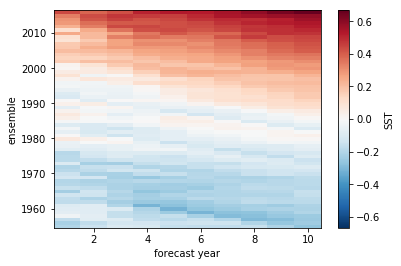

In [124]:
DPLE_mean[varname].plot()

### Lead Year 1 timeseries for all members

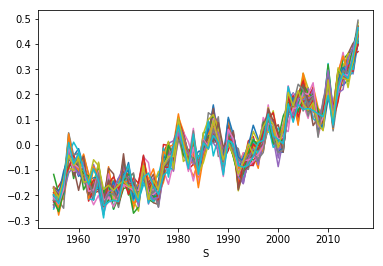

In [125]:
DPLE.sel(L=1).to_dataframe()[varname].unstack(0).plot(legend=False)

### ensemble member mean timeseries for all lead years

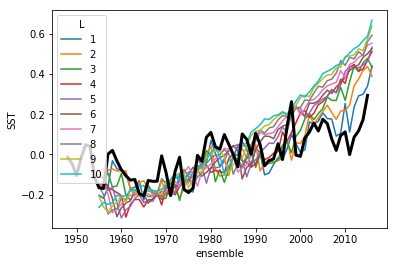

In [126]:
DPLE.mean('M').rename({'S':'ensemble'}).to_dataframe()[varname].unstack(0).plot()
assim[varname].rename({'year':'ensemble'}).plot(lw=3,color='k')

## Rename to match ensemble, member, year

In [127]:
DPLE_renamed = DPLE.rename({'S':'ensemble','M':'member','L':'year'}).sel(ensemble=slice(1955,2015))
assim=assim.rename({'year':'ensemble'}).sel(ensemble=slice(1955,2015))
DPE=DPLE_renamed

# Prediction module for hindcasts

In [134]:
# the comparison functions are basically the same as xr.broadcast (I want 
# to have forecast and truth in the same dimensions), but it this
# implementation here runs at double speed compared to xr.broadcast

def _e2a(DPE, assim):
    """Compare ensemble member mean forecast with assimilation."""
    fct = DPE.mean('member')
    truth = assim.expand_dims('year')
    nyear = DPE.year.size
    truth = truth.isel(year=[0]*nyear)
    truth['year'] = np.arange(1,1+nyear)
    return fct, truth

def _m2a(DPE, assim):
    """Compare every ensemble member forecast with assimilation."""
    fct = DPE
    truth = assim.expand_dims('year').expand_dims('member')
    nyear = DPE.year.size
    nmember = DPE.member.size
    truth = truth.isel(member=[0]*nmember,year=[0]*nyear)
    truth['year'] = np.arange(1,1+nyear)
    truth['member'] = np.arange(1,1+nmember)
    return fct, truth

def hindcast_compute(DPE, assim, metric=_pearson_r, comparison=_e2a, time_dim='ensemble'):
    """
    Compute a predictability skill score for a perfect-model framework simulation dataset.

    Relies on two concepts yielding equal results (see comparisons):
    - np vectorized from xskillscore (_rmse, _pearson_r) but manually 'stacked' (_m2m, m2e, ...)
    - xarray vectorized (_mse, _rmse_v, ...) from ensemble variance (_ens_var_against_mean, _..control)

    Parameters
    ----------
    DPE, assim : Decadal Prediction Ensemble and Assimilation xr.Dataset with
                 time_dim dimension (optional spatial coordinates)
        input data
    metric : function
        metric from [_rmse, _pearson_r]
    comparison : function
        comparison from [_m2a, _e2a]
    time_dim : str
        Name of the time dimension (likely 'year' or 'time')

    Returns
    -------
    res : xr.DataArray or xr.Dataset
        skill score
    """
    if comparison.__name__ not in ['_e2a', '_m2a']:
        raise ValueError('specify comparison argument')

    if metric.__name__ in ['_pearson_r', '_rmse']:
        fct, truth = comparison(DPE,assim)
        res = metric(fct, truth,'ensemble')
        if comparison.__name__ is '_m2a':
            res = res.mean('member')
        return res
    else:
        raise ValueError('specify metric argument')

Approach for bootstrapping: Shuffle ensemble dimension

In [135]:
def _shuffle_ensembles(DPE):
    """Shuffle ensemble dimension for bootstrapping."""
    enslist = DPE.ensemble.values
    ens = enslist.copy()
    np.random.shuffle(enslist)
    DPE_shuffled = DPE.sel(ensemble=enslist)
    DPE_shuffled['ensemble'] = ens
    return DPE_shuffled

def hindcast_sig(DPE, assim, metric=_pearson_r, comparison=_e2a, sig=99, bootstrap=300, time_dim=time_dim):
    """
    Return sig-th percentile of function to be choosen from shuffled DPE.

    Parameters
    ----------
    DPE, assim : xr.DataArray/Dataset with time_dim dimension
        input data
    sig: int or list
        Significance level for bootstrapping from pseudo ensemble
    bootstrap: int
        number of iterations

    Returns
    -------
    sig_level : xr.DataArray/Dataset as inputs
        significance level without time_dim, ensemble and member dimensions
        as many sig_level as listitems in sig

    """
    x = []
    for _ in range(1 + int(bootstrap / DPE['year'].size)):
        ds_pseudo = _shuffle_ensembles(DPE)
        ds_pseudo_metric = hindcast_compute(
            ds_pseudo, assim, metric=metric, comparison=comparison)
        x.append(ds_pseudo_metric)
    ds_pseudo_metric = xr.concat(x, dim='it')
    if isinstance(sig, list):
        qsig = [x / 100 for x in sig]
    else:
        qsig = sig / 100
    sig_level = ds_pseudo_metric.quantile(q=qsig, dim=['year', 'it'])
    return sig_level

In [136]:
def get_limit_sig(metric=pearson_r,sig=99):
    if metric.__name__ in ['_pearson_r', '_PPP', '_PM_MSSS']:
        limit = 'upper'
        sigl = sig
    else:
        limit = 'lower'
        sigl = 100 - sig
    return limit, sigl

Notes
---
- I think we are making our coding very difficult with the time_dim argument. Isnt it much easier if we just agree whether to use time or year? Independent of the choice we make, do we need to have this flexible? To me it seems much easier to rename dimensions in the beginning and then just run the code.
- Now this code can only compute the metrics ACC and RMSE because those are implemented based on numpy in xskillscore https://github.com/raybellwaves/xskillscore. 
    - What do you think about adding the few needed metrics by ourselves? MSE, MAE can be probably easily adapted from this.
- So far the rest of the prediction module works always on xr.Datasets (and mostly also for xr.DataArrays). 

# Prediction skill

In [51]:
bootstrap=1000
sig=99

## raw anomaly data

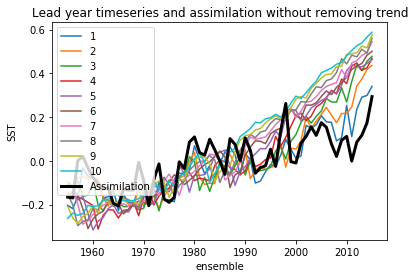

In [139]:
DPE.mean('member').to_dataframe()[varname].unstack().plot()
assim[varname].plot(lw=3,color='k',label='Assimilation')
plt.title('Lead year timeseries and assimilation without removing trend')
plt.legend()

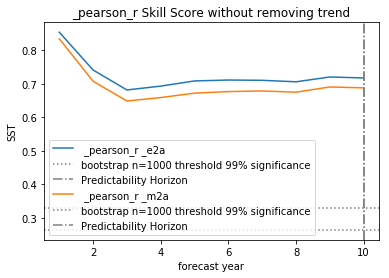

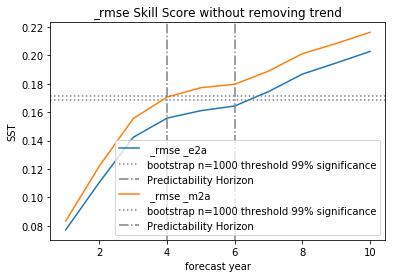

In [140]:
for metric in [_pearson_r,_rmse]:
    limit, sigl = get_limit_sig(metric=metric, sig=sig)
    for comparison in [_e2a,_m2a]:
        # compute hindcast skill
        skill = hindcast_compute(DPE, assim,metric=metric,comparison=comparison)
        skill[varname].plot(label=' '+metric.__name__+' '+comparison.__name__)
        # bootstrap threshold
        threshold = hindcast_sig(DPE,assim, metric=metric,comparison=comparison, bootstrap=bootstrap, sig=sigl)[varname].values
        plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
        ph = xr_predictability_horizon(skill, threshold, limit=limit)[varname].values
        plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
    plt.legend()
    plt.title(metric.__name__+' Skill Score without removing trend')
    plt.show()

quite high (artificial) ACC prediction skill due to climate change forcing

## detrend by linear fit

In [141]:
n=1
detrended_DPE = esmtools.stats.xr_rm_poly(DPE[varname],n, dim='ensemble').to_dataset(varname)
detrended_assim = esmtools.stats.xr_rm_poly(assim[varname],n, dim='ensemble').to_dataset(varname)

/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Lead year timeseries and assimilation after removing linear trend')

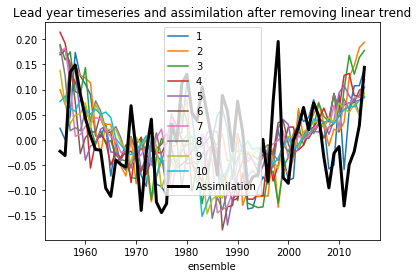

In [142]:
detrended_DPE.mean('member').to_dataframe()[varname].unstack().plot()
detrended_assim.to_dataframe()[varname].plot(lw=3,color='k',label='Assimilation')
plt.legend()
plt.title('Lead year timeseries and assimilation after removing linear trend')

probably a 2nd order polynomial does better

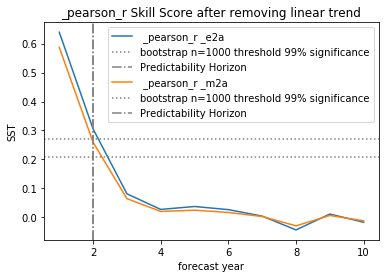

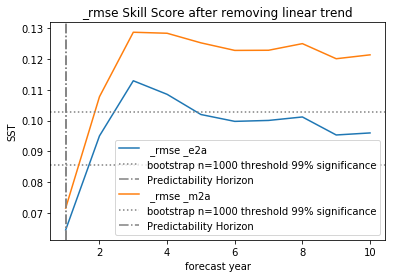

In [58]:
for metric in [_pearson_r,_rmse]:
    limit, sigl = get_limit_sig(metric=metric, sig=sig)
    for comparison in [_e2a,_m2a]:
        # compute hindcast skill
        skill = hindcast_compute(detrended_DPE, detrended_assim,metric=metric,comparison=comparison)
        skill[varname].plot(label=' '+metric.__name__+' '+comparison.__name__)
        # bootstrap threshold
        threshold = hindcast_sig(detrended_DPE,detrended_assim, metric=metric, comparison=comparison, bootstrap=bootstrap, sig=sigl)[varname].values
        plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
        ph = xr_predictability_horizon(skill, threshold, limit=limit)[varname].values
        plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
    plt.legend()
    plt.title(metric.__name__+' Skill Score after removing linear trend')
    plt.show()

## detrend via n-th order polynomial

In [85]:
n=2
polyndetrended_DPE = esmtools.stats.xr_rm_poly(DPE[varname],n, dim='ensemble').to_dataset(varname)
polyndetrended_assim = esmtools.stats.xr_rm_poly(assim[varname],n, dim='ensemble').to_dataset(varname)

/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  
/Users/aaron.spring/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Lead year timeseries and assimilation after removing n-th order polynomial trend')

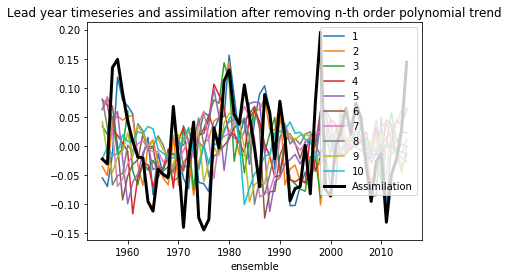

In [86]:
polyndetrended_DPE.mean('member').to_dataframe()[varname].unstack().plot()
detrended_assim.to_dataframe()[varname].plot(lw=3,color='k',label='Assimilation')
plt.legend()
plt.title('Lead year timeseries and assimilation after removing n-th order polynomial trend')

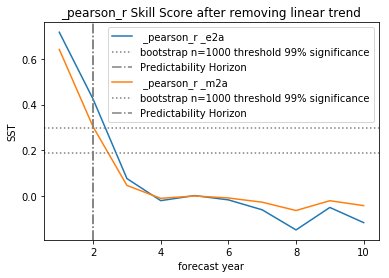

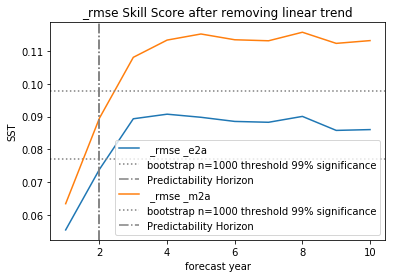

In [87]:
for metric in [_pearson_r,_rmse]:
    limit, sigl = get_limit_sig(metric=metric, sig=sig)
    for comparison in [_e2a,_m2a]:
        # compute hindcast skill
        skill = hindcast_compute(polyndetrended_DPE, polyndetrended_assim,metric=metric,comparison=comparison)
        skill[varname].plot(label=' '+metric.__name__+' '+comparison.__name__)
        # bootstrap threshold
        threshold = hindcast_sig(polyndetrended_DPE, polyndetrended_assim, metric=metric, comparison=comparison, bootstrap=bootstrap, sig=sigl)[varname].values
        plt.axhline(y=threshold, ls=':',c='gray',label='bootstrap n='+str(bootstrap)+' threshold '+str(sig)+'% significance')
        ph = xr_predictability_horizon(skill, threshold, limit=limit)[varname].values
        plt.axvline(x=ph,ls='-.',c='gray',label='Predictability Horizon')
    plt.legend()
    plt.title(metric.__name__+' Skill Score after removing linear trend')
    plt.show()

##  detrend via unitialised ensemble mean from CESM LE 